# Amazon EC2 Spot Pricing

Chart the price history of GPU based Amazon EC2 Spot instances.

## References

* [Watch your AWS Bill!](https://console.aws.amazon.com/billing/home?region=us-east-1)
* [Get Spot Price History](http://boto.readthedocs.org/en/latest/ref/ec2.html#boto.ec2.connection.EC2Connection.get_spot_price_history)
* [Example EC2 Spot Price Comparison](https://github.com/MozillaSecurity/ec2SpotPrices)
* [Boto Implementation for Spot Price History](https://github.com/turnkeylinux/python-boto/blob/master/boto/ec2/spotpricehistory.py)
* [Amazon Instance Types](https://aws.amazon.com/ec2/instance-types/)
* [EC2 AMI with Caffe and Torch](http://blog.titocosta.com/post/110345699197/public-ec2-ami-with-torch-and-caffe-deep-learning)
* [AWS Credentials File](http://docs.aws.amazon.com/aws-sdk-php/v2/guide/credentials.html#credential-profiles)
* [AWS Regions](http://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-regions-availability-zones.html#concepts-regions)
* [AWS Spot Bid Advisor](https://aws.amazon.com/ec2/spot/bid-advisor/)
* [NBAGG Matplotlib Backend](http://matplotlib.org/users/whats_new.html#the-nbagg-backend)

In [9]:
# Get Spot Price History for EC2 GPU instances in all regions.
import boto
import boto.ec2
import datetime
import dateutil.parser
import logging
from collections import namedtuple


# We're going to use a limited set of Region information to view instead of the full SpotPriceHistory
# object, more fields are available and found in the"Boto Implementation for Spot Price History".
RegionSpotPrice = namedtuple("RegionSpotPrice", ["region_name", "region_id", "price", "timestamp"])


# A logger to keep from a bunch of print statements :/
logger = logging.getLogger("Amazon EC2 Spot Pricing")
logger.setLevel(logging.DEBUG)


# We get the Spot Price History in order to judge the price which we think we can bid on and keep.
# All the AWS regions, see "AWS Regions" or call boto.ec2.regions() and remove government regions.
# NOTE not all regions have g2.2xlarge spot instances.
AWS_REGIONS = {
    "ap-northeast-1": "Asia Pacific (Tokyo)",
    "ap-southeast-1": "Asia Pacific (Singapore)",
    "ap-southeast-2": "Asia Pacific (Sydney)",
    "eu-central-1": "EU (Frankfurt)",
    "eu-west-1": "EU (Ireland)",
    "sa-east-1": "South America (Sao Paulo)",
    "us-east-1": "US East (N. Virginia)",
    "us-west-1": "US West (N. California)",
    "us-west-2": "US West (Oregon)",
}

# From 10 days ago until now.
# NOTE watchout for UTC offset.
END_TIME = datetime.datetime.now()
START_TIME = END_TIME - datetime.timedelta(days=10)

def get_region_gpu_spot_price_history(aws_region, start_time, end_time):
    """
    Connect to ec2 with boto and get the spot price history for g2.2xlarge instances of
    Linux/UNIX.
    
    Parameters
    ----------
    aws_region : string
        An AWS region ID.
    start_time : str(isoformat)
        Time in the past to start looking for history from.
    end_time : str(isoformat)
        The most recent time to get history from.
        
    Yields
    -------
    spot_price_history : list(SpotPriceHistory)
        For this region only, a page of SpotPriceHistory.
    """
    ec2_conn = boto.ec2.connect_to_region(
        region_name=aws_region,
        profile_name="cedarstreet"       # This is *your* aws profile name.
        )

    next_token = None
    while True:
        spot_price_history = ec2_conn.get_spot_price_history(
            start_time=start_time,
            end_time=end_time,
            next_token=next_token,           # There may be more than one "page" of spot price history.
            instance_type="g2.2xlarge",      # See "Amazon Instance Types", the G2 2XLarge is smallest GPU.
            product_description="Linux/UNIX" # The AMI is for Linux/UNIX instance types.
            )

        yield spot_price_history
        
        if spot_price_history.next_token:
            logger.debug("Getting more price history.")
            next_token = spot_price_history.next_token
        else:
            logger.debug("Finished getting price history.")
            break


def get_all_region_gpu_spot_price_history():
    """
    Get the last 10 days of spot price history for g2.2xlarge instances in every region.
    
    Returns
    -------
    all_region_price_history : list(RegionSpotPrice)
        All the region instance prices.
    """
    # Connect to each region and record the last 10 days of spot price history for g2.2xlarge.
    all_region_price_history = []
    for aws_region, aws_region_name in AWS_REGIONS.iteritems():
        logger.info("Getting history for %s", aws_region_name)
        for region_spot_price_history in get_region_gpu_spot_price_history(
                aws_region, START_TIME.isoformat(), END_TIME.isoformat()):
            # Since some regions don't have any g2.2xlarge instances, we skip them.
            if region_spot_price_history is not None:
                # Converting the response to the RegionSpotPrice tuple format.
                all_region_price_history += map(
                    lambda r: RegionSpotPrice(
                        region_name=aws_region_name,
                        region_id=aws_region,
                        price=r.price,
                        timestamp=dateutil.parser.parse(r.timestamp)),
                    region_spot_price_history)
            else:
                logger.warning("%s has no g2.2xlarge instances.", aws_region)

    return all_region_price_history

In [10]:
# Initialize common charting libraries, add pandas for conversion.
import pandas as pd
import seaborn as sns

%matplotlib nbagg
sns.set_context('notebook', font_scale=2.0)

# Change color palette to work for those who aren't able to see the default palette well.
CMAP = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple", "reddish", "greenish", "black", "purpleish"])
sns.set_style("whitegrid")

In [11]:
# Get all region spot price history.
all_region_price_history = get_all_region_gpu_spot_price_history()

INFO:Amazon EC2 Setup:Getting history for Asia Pacific (Singapore)
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Finished getting price history.
INFO:Amazon EC2 Setup:Getting history for Asia Pacific (Sydney)
DEBUG:Amazon EC2 Setup:Finished getting price history.
INFO:Amazon EC2 Setup:Getting history for US West (Oregon)
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Finished getting price history.
INFO:Amazon EC2 Setup:Getting history for US East (N. Virginia)
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Getting more price history.
DEBUG:Amazon EC2 Setup:Finished getting price history.
INFO:Amazon EC2 Setup:Getting history for Asia Pacific (Tokyo)
DEBUG:Amazon EC2 Setup:Finished getting price history.
INFO:Amazon EC2 Setup:Getting history for US West (

In [12]:
# Start with a DataFrame of all the Regions then split out by region and we want to get the daily mean
# instead of the random samples which were returned from Amazon.
df = pd.DataFrame(
    all_region_price_history,
    columns=["Region", "Region ID", "Price (USD)", "Time"])
df.set_index(["Region", "Time"], inplace=True)

df.groupby(level="Region").apply(lambda g: g["Price (USD)"].describe())

Price (USD),count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Asia Pacific (Singapore),1999,0.402102,0.569654,0.0800,0.09350,0.13370,0.2224,2.000
Asia Pacific (Sydney),338,0.144378,0.183332,0.0907,0.09530,0.09955,0.1007,1.000
Asia Pacific (Tokyo),450,0.451161,0.313993,0.1165,0.17965,0.36100,0.8981,1.000
EU (Frankfurt),5478,0.121778,0.087172,0.0789,0.08000,0.09840,0.1223,1.000
EU (Ireland),10586,0.146108,0.288871,0.0814,0.09040,0.10470,0.1431,7.020
US East (N. Virginia),5940,0.146617,0.444576,0.0640,0.06690,0.07000,0.0763,5.025
US West (N. California),9974,0.093660,0.133716,0.0674,0.07410,0.07810,0.0866,7.000
US West (Oregon),1672,0.099388,0.243361,0.0657,0.06720,0.06960,0.0754,6.500


<IPython.core.display.Javascript object>


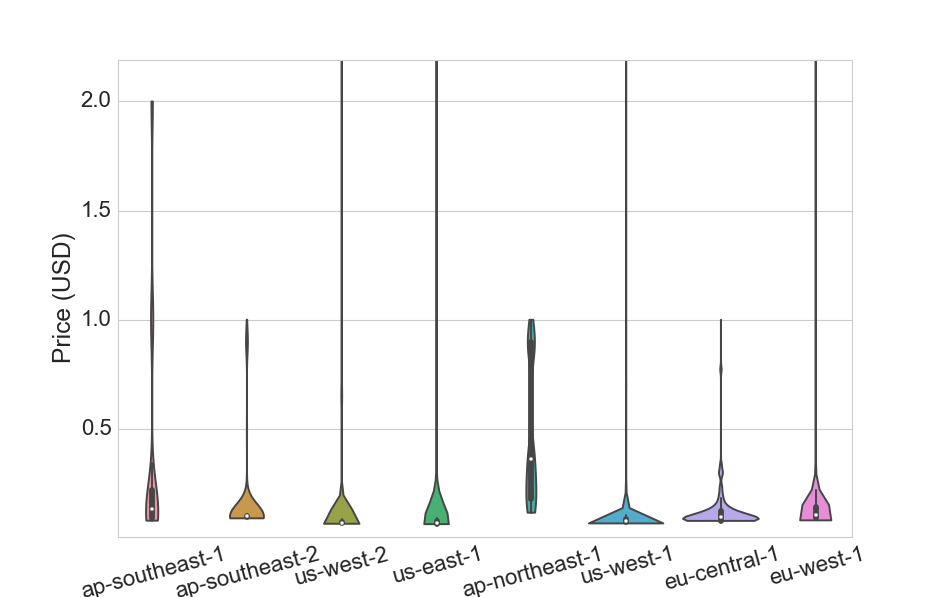

[None, None, None, None, None, None, None, None]

In [16]:
# View a distribution probability box plot to help ID good prices to use.
%matplotlib nbagg

sns.violinplot("Region ID", "Price (USD)", data=df, cut=0.0, aspect=1.7)
locs, labels = sns.plt.xticks()
sns.plt.setp(labels, rotation=15)

In [14]:
# Let's turn the daily grouped prices into something we can use in SeaBorn by grouping the samples into their
# region and then group again at the daily level. This allows us to get daily sampled information about each
# region's prices.
daily_group = df.groupby(level="Region").apply(
    lambda g: g.groupby(pd.TimeGrouper('D', level="Time")))

# Get a time span for the list of the past 10 days, this is to get away from skew caused by
# crossing timezones.
time_span = list(pd.date_range(START_TIME, END_TIME, freq="D", tz="UTC", normalize=True))

# We will want a tuple which consists of a Region, Price, Time Sample Index (Days Ago) and
# a Unit associated with each sample which we use inappropriately to get an idea of the deviation
# of each day's prices from that day's mean price.
daily_prices = []
for region, daily in daily_group.iteritems():
    for day, time_series in daily:
        if not day in time_span:
            logger.debug("Removing time because of UTC offset skew: %s", day)
            continue
        
        # Seaborn will expect a time sample integer which will be the sample number.
        time_index = time_span.index(day)
        
        # This day's set of prices.
        day_prices = time_series["Price (USD)"]
        stddev = day_prices.std()
        mean = day_prices.mean()
        daily_prices.append((region, mean, time_index, 0))
        
        # NOTE This is to give me an idea of the std deviation for each price and region, it is not the
        # proper usage of a tsplot! I believe if a statistician saw this they may threaten physical harm.
        #
        # If you'd like to understand how these samples work together with a tsplot, I highly recommend
        # reading this wiki: https://en.wikipedia.org/wiki/Confidence_interval
        daily_prices.append((region, mean + stddev / 2, time_index, 1))
        daily_prices.append((region, mean - stddev / 2, time_index, 2))

# Notice the use of short names for DataFrames, this is mainly because I often use the Numerical Expession querying
# of Pandas. A better usage would be expressive names and using the #query method available on each DataFrame.
sdf = pd.DataFrame(
    daily_prices,
    columns=["Region", "Price (USD)", "Time", "Unit"])
sdf.sort("Time", inplace=True)
sdf[0:5]

DEBUG:Amazon EC2 Setup:Removing time because of UTC offset skew: 2015-09-27 00:00:00+00:00


,Region,Price (USD),Time,Unit
0,Asia Pacific (Singapore),1.500000,0,0
198,US West (N. California),0.809752,0,0
33,Asia Pacific (Sydney),0.899050,0,0
34,Asia Pacific (Sydney),0.899722,0,1
35,Asia Pacific (Sydney),0.898378,0,2


<IPython.core.display.Javascript object>


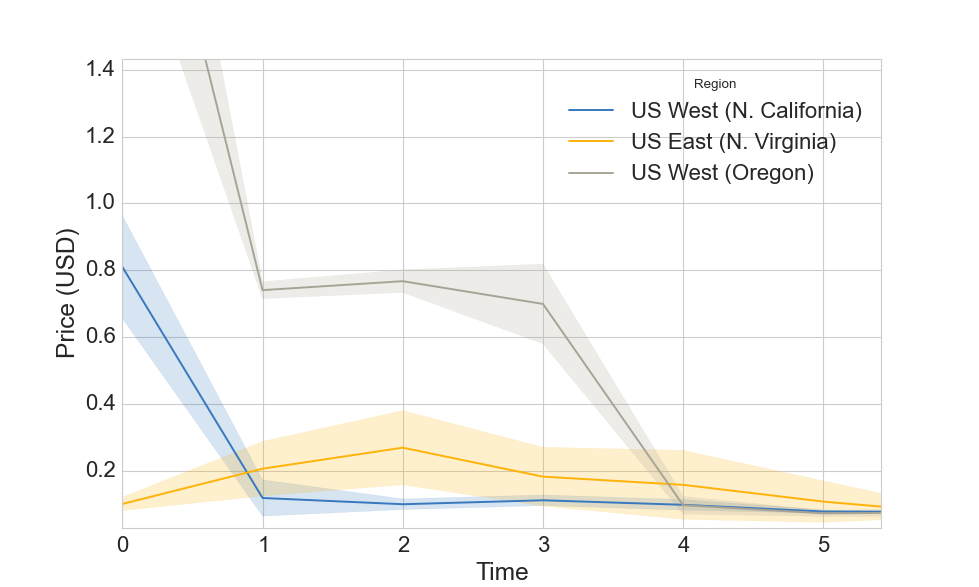

In [17]:
%matplotlib nbagg

# Prices for on demand instances always seems to be outdated, I haven't
# discovered a programatic approach to get them yet so using this page
# to compare:
# https://aws.amazon.com/ec2/pricing/
sns.tsplot(
    data=sdf[
        (sdf.Region == "US West (N. California)")
        | (sdf.Region == "US East (N. Virginia)")
        | (sdf.Region == "US West (Oregon)")],
    condition="Region",
    unit="Unit",
    value="Price (USD)",
    time="Time",
    legend=True,
    color=CMAP)